# Micro-Expressions Classification

In [34]:
# importing required libraries
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

## Classes

In [35]:
# Classes
datasetDir = "../input/micro-expressions/Micro_Expressions"
classes = os.listdir(datasetDir + "/train")
print("Expression Labels: ",classes)

Expression Labels:  ['surprise', 'fear', 'neutral', 'sadness', 'disgust', 'happiness', 'anger']


## Using Data Augmentation to increase dataset size (reflect-padding, and random-horizontal flip)

In [36]:
# data augmentation (reflect-padding, and random-horizontal flip)
tfms = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
#Loading the dataset as pyTorch Tensors
dataset1 = ImageFolder(datasetDir+"/train",tfms)
dataset2 = ImageFolder(datasetDir+"/train",transform=ToTensor())
#Combining normal dataset and augmented dataset
dataset = dataset1+dataset2
dataset.classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

## Visualizing data

In [37]:
# visualising dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(image, label):
    print("Label: ",dataset.classes[label])
    plt.imshow(image.permute(1,2,0)) #rgb channel at last in matplot (1st in PyTorch Tensor)

Label:  anger


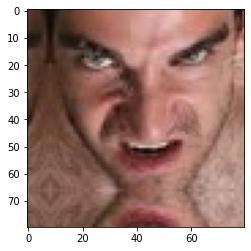

In [38]:
# an example from the dataset
show_image(*dataset[100])

## Training and Validation Set

In [39]:
# Splitting dataset into training and validataion set using random_split
randomSeed = 3 #to always create same validation set
torch.manual_seed(randomSeed)
valSize = 2000
trainSize = len(dataset)-valSize
trainDS, valDS = random_split(dataset,[trainSize,valSize])
print("No. of training data: ",len(trainDS))
print("No. of validation data: ",len(valDS))

No. of training data:  11876
No. of validation data:  2000


In [40]:
#Creating data loaders
from torch.utils.data.dataloader import DataLoader
batchSize = 200
trainDL = DataLoader(trainDS,batchSize,shuffle=True,num_workers=4, pin_memory=True)
valDL = DataLoader(valDS,batchSize*2,num_workers=4, pin_memory=True)

## Visualizing Batch data

In [41]:
# Visualizing Batch data
from torchvision.utils import make_grid

def showBatch(DL):
    for images, labels in DL:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([]) #blank label axes
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

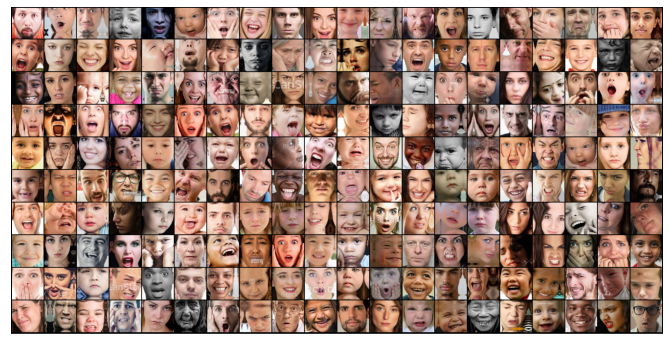

In [42]:
showBatch(trainDL)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
# Some Useful Functions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images) # predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels) # accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs): # for epoch validation loss and accuracy
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {} , train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## CNN Model

In [45]:
# CNN Model
class MERCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 40 x 40
    
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 20 x 20
    
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 10 x 10
    
            nn.Flatten(),
            nn.Linear(256*10*10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [46]:
# Model structure
model = MERCnnModel()
print(model)

MERCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25600, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

## Device selection

In [47]:
# to select GPU if available or else CPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# to move tensor to selected device
def to_device(data, device): 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# to wrap a dataloader to move data to the device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self): # batch of data
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self): # no. of batches
        return len(self.dl)

In [48]:
device = get_default_device()
print("Selected device:",device)

Selected device: cuda


In [49]:
# Wrapping training and validation dataloader
train_dl = DeviceDataLoader(trainDL, device)
val_dl = DeviceDataLoader(valDL, device)
to_device(model, device);

In [50]:
@torch.no_grad() # do not track gradient
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model Training

In [51]:
# Training
model = to_device(MERCnnModel(), device)
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 0 , train_loss: 1.9240, val_loss: 1.8510, val_acc: 0.2485
Epoch 1 , train_loss: 1.8137, val_loss: 1.7018, val_acc: 0.3430
Epoch 2 , train_loss: 1.6061, val_loss: 1.5911, val_acc: 0.3660
Epoch 3 , train_loss: 1.4309, val_loss: 1.3732, val_acc: 0.4955
Epoch 4 , train_loss: 1.2438, val_loss: 1.2464, val_acc: 0.5340
Epoch 5 , train_loss: 1.0886, val_loss: 1.1085, val_acc: 0.5805
Epoch 6 , train_loss: 0.9599, val_loss: 0.9900, val_acc: 0.6345
Epoch 7 , train_loss: 0.8484, val_loss: 0.9972, val_acc: 0.6415
Epoch 8 , train_loss: 0.7780, val_loss: 0.8502, val_acc: 0.6895
Epoch 9 , train_loss: 0.6770, val_loss: 0.8458, val_acc: 0.6960
Epoch 10 , train_loss: 0.6128, val_loss: 0.8236, val_acc: 0.7050
Epoch 11 , train_loss: 0.5725, val_loss: 0.7654, val_acc: 0.7315
Epoch 12 , train_loss: 0.5196, val_loss: 0.7840, val_acc: 0.7210
Epoch 13 , train_loss: 0.4922, val_loss: 0.7461, val_acc: 0.7515
Epoch 14 , train_loss: 0.4479, val_loss: 0.7720, val_acc: 0.7525
Epoch 15 , train_loss: 0.4427, val_

## Validation Accuracy

In [52]:
# Validation accuracy
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

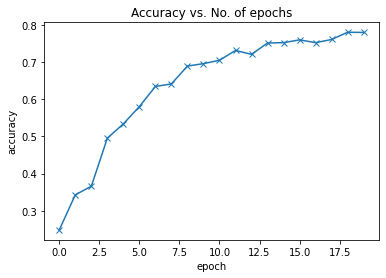

In [53]:
plot_accuracies(history)

## Training and Validation loss

In [54]:
# Training and validation loss
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

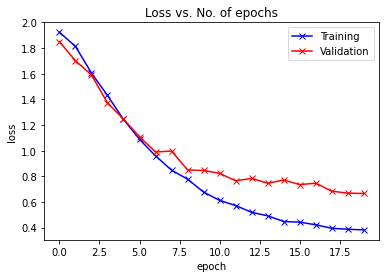

In [55]:
plot_losses(history)

## Prediction on testset

In [58]:
# Test set prediction
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device) # Convert to a batch of 1   
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1) # pick class with highest probability
    return dataset.classes[preds[0].item()] # return class label

Label: anger , Predicted: anger


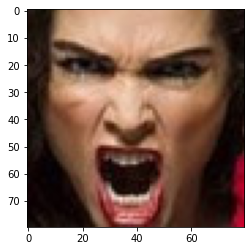

In [59]:
test_dataset = ImageFolder(datasetDir+'/test', transform=ToTensor())
image, label = test_dataset[112]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))

## Testset accuracy

In [61]:
# Test set accuracy
test_loader = DeviceDataLoader(DataLoader(test_dataset, batchSize*2), device)
result = evaluate(model, test_loader)
print("test loss:",result['val_loss']) # in evaluate -> validation_step function its named val_loss and val_acc, so renamed here for testset
print("test accuracy:",result['val_acc'])

test loss: 0.6769786477088928
test accuracy: 0.8145000338554382


## Saving the model

In [62]:
# torch.save(model.state_dict(),'MERCnn.pth')

In [63]:
# modelSaved = to_device(MERCnnModel(),device)
# modelSaved.load_state_dict(torch.load('MERCnn.pth'))